In [1]:
from emukit.test_functions import forrester_function
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
import numpy as np
import pandas as pd
import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import matplotlib.pyplot as plt
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


# COVID-19 Analysis Using Data From Marseille, France 

- It mainly consists of three parts:
    - data cleaning
    - bayesian optimization step by step
    - Bayesian Optimization Loop

## Idea of this Project
- The main goal of this project is to use Bayesian Optimization to find the optimal number of tree and the optimal max_depth parameters of a Random Forest Tree Classifier. 
- The benefit of Bayesian Optimization is its fast searching for optimal points to evaluate, thus saving time to find the optimal point.
- In order to use a Bayesian Optimization method, we need a target function which is the function we want to minimize. In this case, we set the loss of the classifier as the function.
- We used Expected Improvement as the acquisition function, because it's well known for taking both the uncertainty of f(x) given x and the objective of f(x).
- We will mainly use Emukit to build a Gaussian Process Model to optimize the parameters, given that the loss of a model with fixed parameter values should have a normal distribution.
- We will see how Bayesian Optimization optimized the two parameters. In particular, the process of optimizing the number of trees is visually presented.

## Data Cleaning

In [2]:
# read data
mar_data = pd.read_csv("dataIHU.csv")
mar_data

,Patient,Age_in_years,Sex,Clinical status,Time_between_onset of\nsymptoms_and_inclusion_in_days,Hydroxychloroquine\ntreatment,Hydroxychloroquine_serum_concentration_μg/ml_in_day_of_dosage,Azithromycin_treatment,D0,D1,D2,D3,D4,D5,D6
0,1,10,M,Asymptomatic,NaN,No,NaN,No,31,NEG,NEG,NEG,NEG,NEG,NEG
1,2,12,F,Asymptomatic,NaN,No,NaN,No,26,ND,33,34,NEG,34,NEG
2,3,14,F,Asymptomatic,NaN,No,NaN,No,26,31,23,22,27,NEG,26
3,4,10,M,Asymptomatic,NaN,No,NaN,No,24,NEG,33,33,NEG,NEG,32
4,5,20,M,upper tract respiratory infection,4.0,No,NaN,No,24,24,24,27,NEG,31,29
5,6,65,F,upper tract respiratory infection,2.0,No,NaN,No,POS,ND,POS,ND,POS,ND,POS
6,7,46,M,upper tract respiratory infection,NaN,No,NaN,No,28,ND,ND,ND,26,ND,30
7,8,69,M,lower tract respiratory infection,2.0,No,NaN,No,POS,ND,POS,ND,POS,POS,POS
8,9,62,F,lower tract respiratory infection,10.0,No,NaN,No,POS,ND,POS,ND,POS,ND,POS
9,10,66,F,upper tract respiratory infection,0.0,No,NaN,No,POS,ND,POS,ND,ND,ND,POS


In [3]:
# Convert NEG in Day 6 to 0
converter_1 = lambda x: 0 if x == 'NEG' else x
converter_2 = lambda x: 1 if x == 'POS' else x
converter_3 = lambda x: 1 if x == 'ND' else x
converter_4 = lambda x: 1 if int(x) > 0 else x
mar_data['D6'] = mar_data['D6'].apply(converter_1)
mar_data['D6'] = mar_data['D6'].apply(converter_2)
mar_data['D6'] = mar_data['D6'].apply(converter_3)
mar_data['D6'] = mar_data['D6'].apply(converter_4)
mar_data

,Patient,Age_in_years,Sex,Clinical status,Time_between_onset of\nsymptoms_and_inclusion_in_days,Hydroxychloroquine\ntreatment,Hydroxychloroquine_serum_concentration_μg/ml_in_day_of_dosage,Azithromycin_treatment,D0,D1,D2,D3,D4,D5,D6
0,1,10,M,Asymptomatic,NaN,No,NaN,No,31,NEG,NEG,NEG,NEG,NEG,0
1,2,12,F,Asymptomatic,NaN,No,NaN,No,26,ND,33,34,NEG,34,0
2,3,14,F,Asymptomatic,NaN,No,NaN,No,26,31,23,22,27,NEG,1
3,4,10,M,Asymptomatic,NaN,No,NaN,No,24,NEG,33,33,NEG,NEG,1
4,5,20,M,upper tract respiratory infection,4.0,No,NaN,No,24,24,24,27,NEG,31,1
5,6,65,F,upper tract respiratory infection,2.0,No,NaN,No,POS,ND,POS,ND,POS,ND,1
6,7,46,M,upper tract respiratory infection,NaN,No,NaN,No,28,ND,ND,ND,26,ND,1
7,8,69,M,lower tract respiratory infection,2.0,No,NaN,No,POS,ND,POS,ND,POS,POS,1
8,9,62,F,lower tract respiratory infection,10.0,No,NaN,No,POS,ND,POS,ND,POS,ND,1
9,10,66,F,upper tract respiratory infection,0.0,No,NaN,No,POS,ND,POS,ND,ND,ND,1


In [4]:
# convert hydroxychloquine treatment to number
converter_hy = lambda x: 0 if x == 'No' else 1
mar_data['Hydroxychloroquine\ntreatment'] = mar_data['Hydroxychloroquine\ntreatment'].apply(converter_hy)
mar_data

,Patient,Age_in_years,Sex,Clinical status,Time_between_onset of\nsymptoms_and_inclusion_in_days,Hydroxychloroquine\ntreatment,Hydroxychloroquine_serum_concentration_μg/ml_in_day_of_dosage,Azithromycin_treatment,D0,D1,D2,D3,D4,D5,D6
0,1,10,M,Asymptomatic,NaN,0,NaN,No,31,NEG,NEG,NEG,NEG,NEG,0
1,2,12,F,Asymptomatic,NaN,0,NaN,No,26,ND,33,34,NEG,34,0
2,3,14,F,Asymptomatic,NaN,0,NaN,No,26,31,23,22,27,NEG,1
3,4,10,M,Asymptomatic,NaN,0,NaN,No,24,NEG,33,33,NEG,NEG,1
4,5,20,M,upper tract respiratory infection,4.0,0,NaN,No,24,24,24,27,NEG,31,1
5,6,65,F,upper tract respiratory infection,2.0,0,NaN,No,POS,ND,POS,ND,POS,ND,1
6,7,46,M,upper tract respiratory infection,NaN,0,NaN,No,28,ND,ND,ND,26,ND,1
7,8,69,M,lower tract respiratory infection,2.0,0,NaN,No,POS,ND,POS,ND,POS,POS,1
8,9,62,F,lower tract respiratory infection,10.0,0,NaN,No,POS,ND,POS,ND,POS,ND,1
9,10,66,F,upper tract respiratory infection,0.0,0,NaN,No,POS,ND,POS,ND,ND,ND,1


In [5]:
# column selection
selected = mar_data[['Hydroxychloroquine\ntreatment', 'D6']]
selected.head()

,Hydroxychloroquine\ntreatment,D6
0,0,0
1,0,0
2,0,1
3,0,1
4,0,1


## Apply Bayesian Optimization

In [6]:
# split the data
X = pd.DataFrame(selected.iloc[:, 0])
y = selected.iloc[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

display(X_train.head())
print(len(X_train))
display(X_test.head())
print(len(X_test))
display(y_train.head())
print(len(y_train))
display(y_test.head())
print(len(y_test))

,Hydroxychloroquine\ntreatment
34,1
0,0
4,0
29,1
15,0


25


,Hydroxychloroquine\ntreatment
35,1
13,0
26,1
30,1
16,1


11


34    0
0     0
4     1
29    1
15    1
Name: D6, dtype: int64

25


35    0
13    1
26    0
30    0
16    1
Name: D6, dtype: int64

11


In [7]:
# define the test function
def target_f(params=np.array([[1, 1]])):
    """
    :return: loss of the model using given parameters
    """
    result = []
    for i in range(len(params)):
        tree_num = params[i][0]
        max_depth = params[i][1]
        rfc = RandomForestClassifier(n_estimators = tree_num, max_depth = max_depth)
        # train the classifier
        rfc.fit(X_train, y_train)
        # report the loss
        loss = 1 - rfc.score(X_test, y_test)
        result.append(loss)
    result = np.array(result).reshape(-1, 1)
    return result

space = ParameterSpace([DiscreteParameter('tree_num', range(1, 100)), DiscreteParameter('max_depth', range(1, 100))])

In [8]:
# create initial value for the model
X_para = np.array([[1, 1], [2, 1]])
y_para = target_f(X_para).reshape(-1, 1)
y_para

array([[0.09090909],
       [0.54545455]])

In [9]:
# set up x and y axes values for plots
x_plot = np.array([range(1, 100)]).reshape(-1, 1)
x_plot = np.array([np.append(x, 1) for x in x_plot])

y_plot = np.array(target_f(x_plot))

 C:\Users\QYK\Anaconda3\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


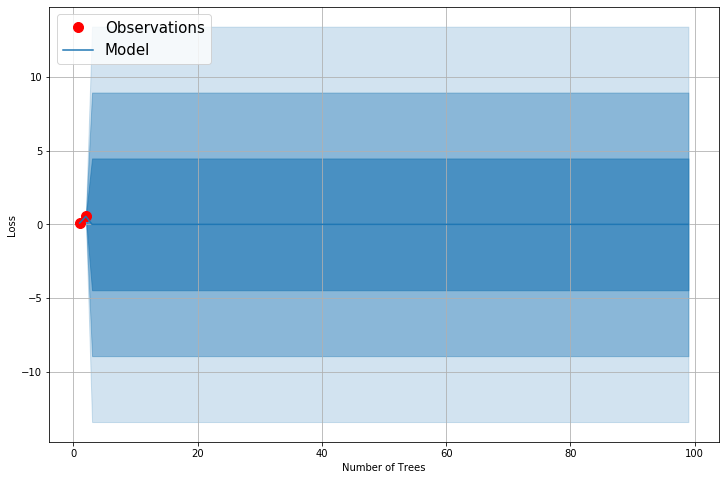

In [10]:
# build a model for the objective function
model_gpy = GPy.models.GPRegression(X_para, y_para, 
                                    GPy.kern.RBF(1, lengthscale=0.08, variance=20), 
                                    noise_var=1e-10)
emukit_model = GPyModelWrapper(model_gpy)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(X_para[:, 0], y_para[:, 0], "ro", markersize=10, label="Observations")
plt.plot(x_plot[:, 0], mu_plot[:, 0], "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel("Number of Trees")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Acqusition Function

In [11]:
# define an acquisition function able to quantify the utility of evaluating each point the input domain
ei_acquisition = ExpectedImprovement(emukit_model)

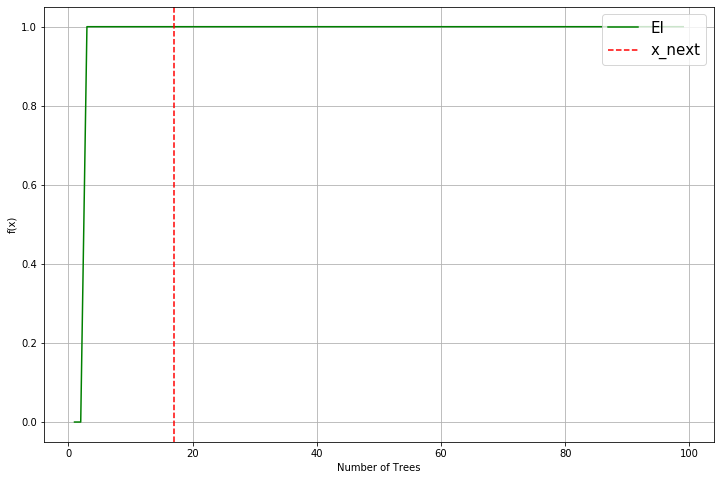

In [12]:
# evaluate the acquisition function and find the next point to evaluate
optimizer = GradientAcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(ei_acquisition)
ei_plot = ei_acquisition.evaluate(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot[:, 0], (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.axvline(x_new[0][0], color="red", label="x_next", linestyle="--")
plt.legend(loc=1, prop={'size': 15})
plt.xlabel("Number of Trees")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

In [13]:
# evaluate the objective function and append the result to initial observation
y_new = target_f(x_new)

X_para = np.append(X_para, x_new).reshape(-1, 2)
y_para = np.append(y_para, y_new).reshape(-1, 1)

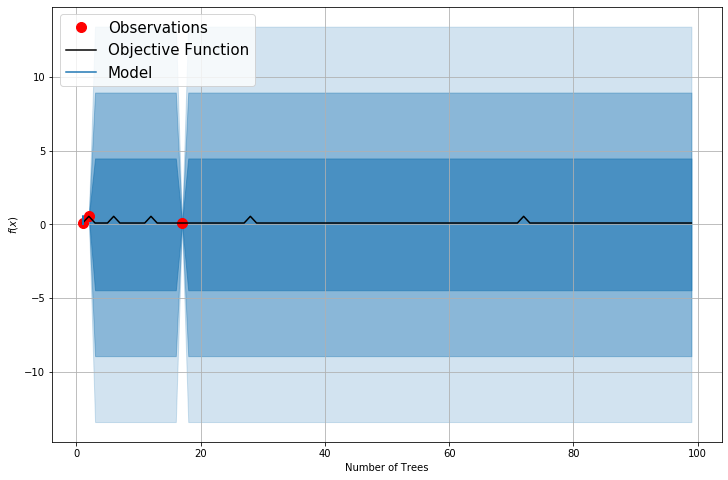

In [14]:
# update the model by setting new data
emukit_model.set_data(X_para, y_para)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(emukit_model.X[:, 0], emukit_model.Y[:, 0], "ro", markersize=10, label="Observations")
plt.plot(x_plot[:, 0], y_plot[:, 0], "k", label="Objective Function")
plt.plot(x_plot[:, 1], mu_plot[:, 0], "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel("Number of Trees")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.show()

- Observation: new data decreases the uncertainty of our data

## Run the Process above 30 times

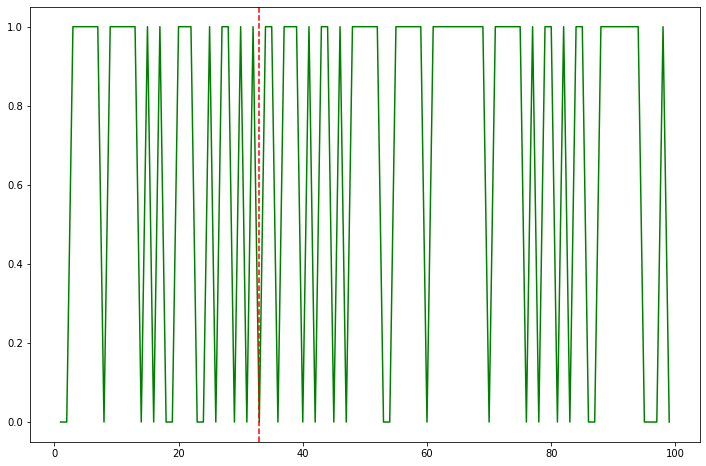

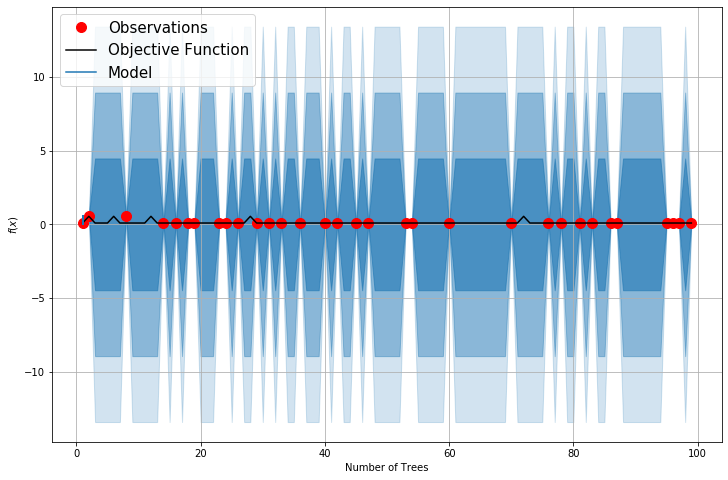

In [15]:
X_para = np.array([[1, 1], [2, 1]])
y_para = target_f(X_para).reshape(-1, 1)
for i in range(30):
    # evaluate the acquisition function and find the next point to evaluate
    optimizer = GradientAcquisitionOptimizer(space)
    x_new, _ = optimizer.optimize(ei_acquisition)
    
    # evaluate the objective function and append the result to initial observation
    y_new = target_f(x_new)

    X_para = np.append(X_para, x_new).reshape(-1, 2)
    y_para = np.append(y_para, y_new).reshape(-1, 1)

    # update the model by setting new data
    emukit_model.set_data(X_para, y_para)

ei_plot = ei_acquisition.evaluate(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot[:, 0], (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)), "green", label="EI")
plt.axvline(x_new[0][0], color="red", label="x_next", linestyle="--")

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(emukit_model.X[:, 0], emukit_model.Y[:, 0], "ro", markersize=10, label="Observations")
plt.plot(x_plot[:, 0], y_plot[:, 0], "k", label="Objective Function")
plt.plot(x_plot[:, 1], mu_plot[:, 0], "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': 15})
plt.xlabel("Number of Trees")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.show()

In [16]:
# report the optimal number of trees and the max depth
print("The optimal number of trees is %d" % x_new[0][0])
print("The optimal depth is %d" % x_new[0][1])

The optimal number of trees is 33
The optimal depth is 35
